## DISCLAIMER AND WARNING: Because of the nature of this project, this report contains words that are very offensive. Needless to say, it is not the intention of the author of this report, and this project, to offend anybody.

# Table of Contents

 - [Text Processing and EDA of the Train Dataset](#Text-Processing-and-EDA-of-the-Train-Dataset) 
 <br>
 
      - [Load and Explore the Data](#Load-and-Explore-the-Data)
           - [Number of comments under each category](#Number-of-comments-under-each-category)
           - [Correlation between categories](#Correlation-between-categories)
           - [Word and character count](#Word-and-character-count)
           - [Word Cloud](#Word-Cloud)
      - [Cleaning and Preprocessing of Text](#Cleaning-and-Preprocessing-of-Text)
           - [Word Cloud Representation After Text Preprocessing](#Word-Cloud-Representation-After-Text-Preprocessing)
      - [EDA Based on Two Non-toxic and Toxic Groups](#EDA-Based-on-Two-Non-toxic-and-Toxic-Groups)
      
      - [Text Vectorizer](#Text-Vectorizer)
          - [Bag of Words (BOW) Model](#Bag-of-Words-(BOW)-Model)
          - [BOW and Ngrams](#BOW-and-Ngrams)
          - [TF-IDF Text-Vectorizer](#TF-IDF-Text-Vectorizer)
          - [TF-IDF and Ngrams](#TF-IDF-and-Ngrams)
      
      - [Save the Data](#Save-the-Data)


# Text Processing and EDA of the Train Dataset

The objective of this notebook is to explore the corpus, clear the text and perform the EDA on the train dataset.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import collections
import nltk
import seaborn as sns
import re
import textblob
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from collections import Counter
from bs4 import BeautifulSoup as bs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 150)
pd.set_option('display.notebook_repr_html', True)

sns.set_context('talk', rc={"grid.linewidth": 0.8})

%matplotlib inline

## Load and Explore the Data

In [2]:
# Read data
train = pd.read_csv('Library/train_df.csv')

In [3]:
train.head()

id                                                                                                                                           comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
0  0000997932d777bf  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I ...      0             0        0       0       0              0
1  000103f0d9cfb60f                                       D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)      0             0        0       0       0              0
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits in...      0             0        0       0       0              0
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of...      0             0        0       0       0              0
4  0001d958c54c6e35                                                                                    You, sir, are my hero. Any chance you remember what page that's on?      0             0        0       0       0              0

### Number of comments under each category

First, let's figure out the number of rows under each category of toxicity. From now on, the non-toxic comments are called "clean comments".

In [4]:
df1 = train.iloc[:, 2:].sum(axis=1)
total_comments = len(df1)
clean_comments = len(df1[df1==0])
tagged_comments = len(df1[df1!=0])

print('Total comments:{}'.format(total_comments))
print('Clean comments:{}'.format(clean_comments))
print('Tagged comments:{}'.format(tagged_comments))

Total comments:159571
Clean comments:143346
Tagged comments:16225


I plot the histogram of the number of comments under each category.

In [5]:
df1 = train[train.columns[2:]].melt()
df1 = df1[df1.value == 1]
df1.head()

variable  value
6     toxic      1
12    toxic      1
16    toxic      1
42    toxic      1
43    toxic      1

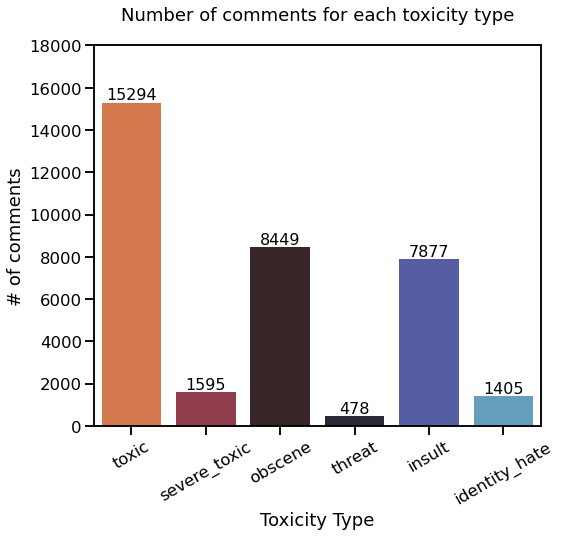

In [6]:
plt.figure(figsize=(8,7))
ax = sns.countplot(x='variable', data=df1, palette='icefire_r')
ax.set(xlabel='Toxicity Type')
ax.set(ylabel='# of comments')
ax.tick_params(axis='x', rotation=30)
plt.title('Number of comments for each toxicity type', y=1.05)
plt.ylim(0,18000)

for i in ax.containers:
    ax.bar_label(i,fontsize=16)
    
plt.show()

The toxicity is not evenly spread out across classes. Therefore, we may face class imbalance problem.
There are 16225 tagged comments in total. While, toxic category only consists of 15294 comments. Obscene and insult categories consist of more than 16000 comments together. Therefore, a comment can be classified as several types.

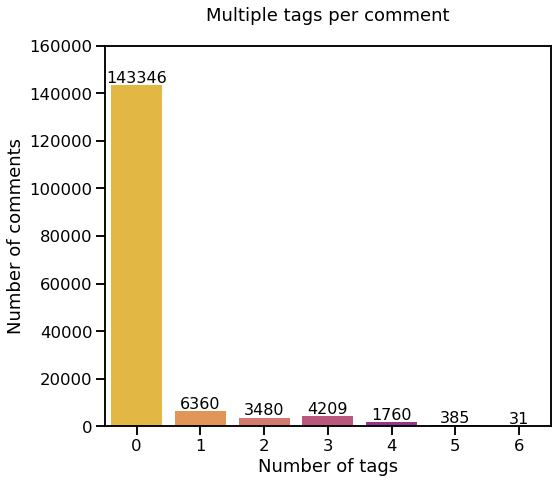

In [7]:
df1 = pd.DataFrame(train.iloc[:, 2:].sum(axis=1))
df1.columns = ['sum']

plt.figure(figsize=(8,7))
ax = sns.countplot(x='sum', data=df1, palette='plasma_r')
ax.set(xlabel='Number of tags')
ax.set(ylabel='Number of comments')
plt.title('Multiple tags per comment', y=1.05)
plt.ylim(0,160000)

for i in ax.containers:
    ax.bar_label(i,fontsize=16)
    
plt.show()

### Correlation between categories

Is there any correlation between the toxic categories?

In [8]:
df = train.iloc[:,2:]
corr = df.corr()
corr

toxic  severe_toxic   obscene    threat    insult  identity_hate
toxic          1.000000      0.308619  0.676515  0.157058  0.647518       0.266009
severe_toxic   0.308619      1.000000  0.403014  0.123601  0.375807       0.201600
obscene        0.676515      0.403014  1.000000  0.141179  0.741272       0.286867
threat         0.157058      0.123601  0.141179  1.000000  0.150022       0.115128
insult         0.647518      0.375807  0.741272  0.150022  1.000000       0.337736
identity_hate  0.266009      0.201600  0.286867  0.115128  0.337736       1.000000

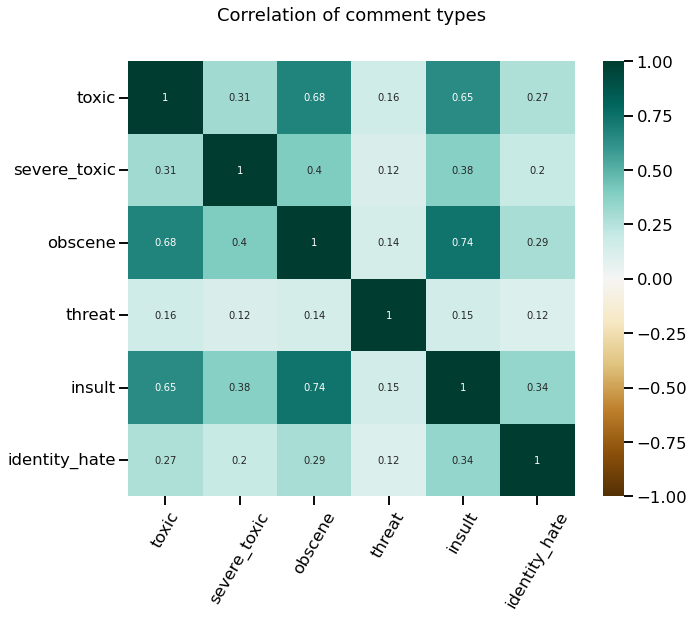

In [9]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.tick_params(axis='y', rotation=0)
heatmap.tick_params(axis='x', rotation=60)
heatmap.set_title('Correlation of comment types', fontdict={'fontsize':18}, y=1.08)
plt.show()

Threat category has the least correlation with the other categories. While insult, obscene and toxic show the highest positive correlation with the other categories. The highest correlation is between obscene and insult.

### Word and character count

In this step, I count the number of tags, number of characters, words and sentences for each comment. Also, number of words and characters per sentences are calculated and added to the dataframe. There might be a pattern in these features.

In [10]:
train.head()

train_df = train
train_df['num_tags'] = train_df.iloc[:, 2:].sum(axis=1) 
train_df['word_count'] = train_df['comment_text'].apply(lambda x: len(nltk.word_tokenize(x)))
train_df['char_count'] = train_df['comment_text'].apply(lambda x: len(x.replace(' ', '')))
train_df['sent_count'] = train_df['comment_text'].apply(lambda x: len(nltk.sent_tokenize(x)))
train_df['avg_char_word'] = train_df['char_count'] / train_df['word_count']
train_df['avg_char_sent'] = train_df['char_count'] / train_df['sent_count']
train_df['avg_word_sent'] = train_df['word_count'] / train_df['sent_count']
train_df.head()

id                                                                                                                                           comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate  num_tags  word_count  char_count  sent_count  avg_char_word  avg_char_sent  avg_word_sent
0  0000997932d777bf  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I ...      0             0        0       0       0              0         0          49         223           3       4.551020      74.333333      16.333333
1  000103f0d9cfb60f                                       D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)      0             0        0       0       0              0         0          27          95           4       3.518519      23.750000       6.750000
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits in...      0             0        0       0       0              0         0          48         192           3       4.000000      64.000000      16.000000
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of...      0             0        0       0       0              0         0         128         511           4       3.992188     127.750000      32.000000
4  0001d958c54c6e35                                                                                    You, sir, are my hero. Any chance you remember what page that's on?      0             0        0       0       0              0         0          18          55           2       3.055556      27.500000       9.000000

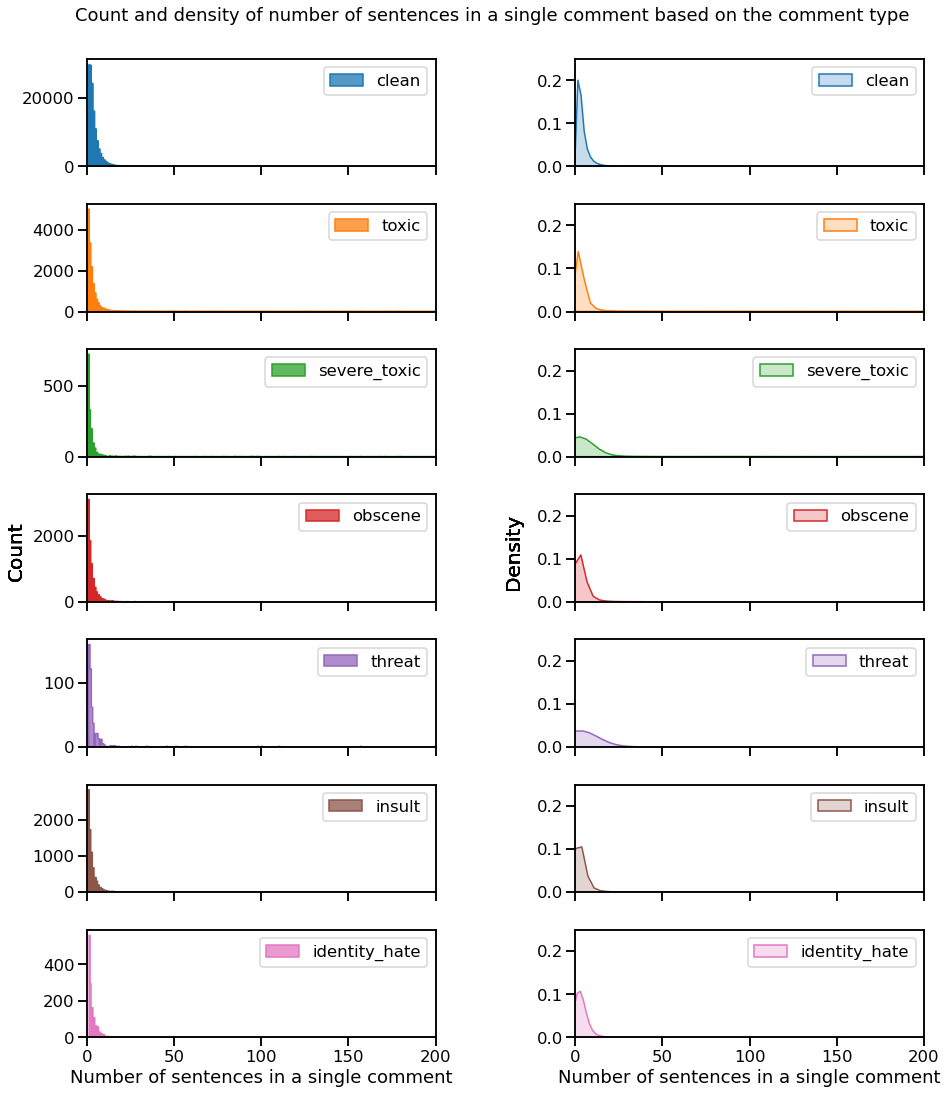

In [11]:
title = 'Count and density of number of sentences in a single comment based on the comment type'

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
plt.subplots_adjust(hspace=0.35, wspace=0.4)
fig.suptitle(title, fontsize=18, y=0.92)
colors = sns.color_palette("tab10", 7)

sns.histplot(data=train_df[train_df['num_tags']==0], x='sent_count', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=train_df[train_df['num_tags']==0]['sent_count'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,200)
ax[0, 1].set_ylim(0,0.25)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in train_df.columns[2:8]:
    
    sns.histplot(data=train_df[train_df[col]==1], x='sent_count', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=train_df[train_df[col]==1]['sent_count'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,200)
    ax[row_count, 1].set_ylim(0,0.25)
    ax[row_count, 0].set_xlabel('Number of sentences in a single comment')
    ax[row_count, 1].set_xlabel('Number of sentences in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
    fig.text(0.52, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20)    
    
    row_count += 1

The non-toxic comments tend to contain less number sentences compared to the toxic comments. Severe toxic and threat comments tend to include more number of sentences.

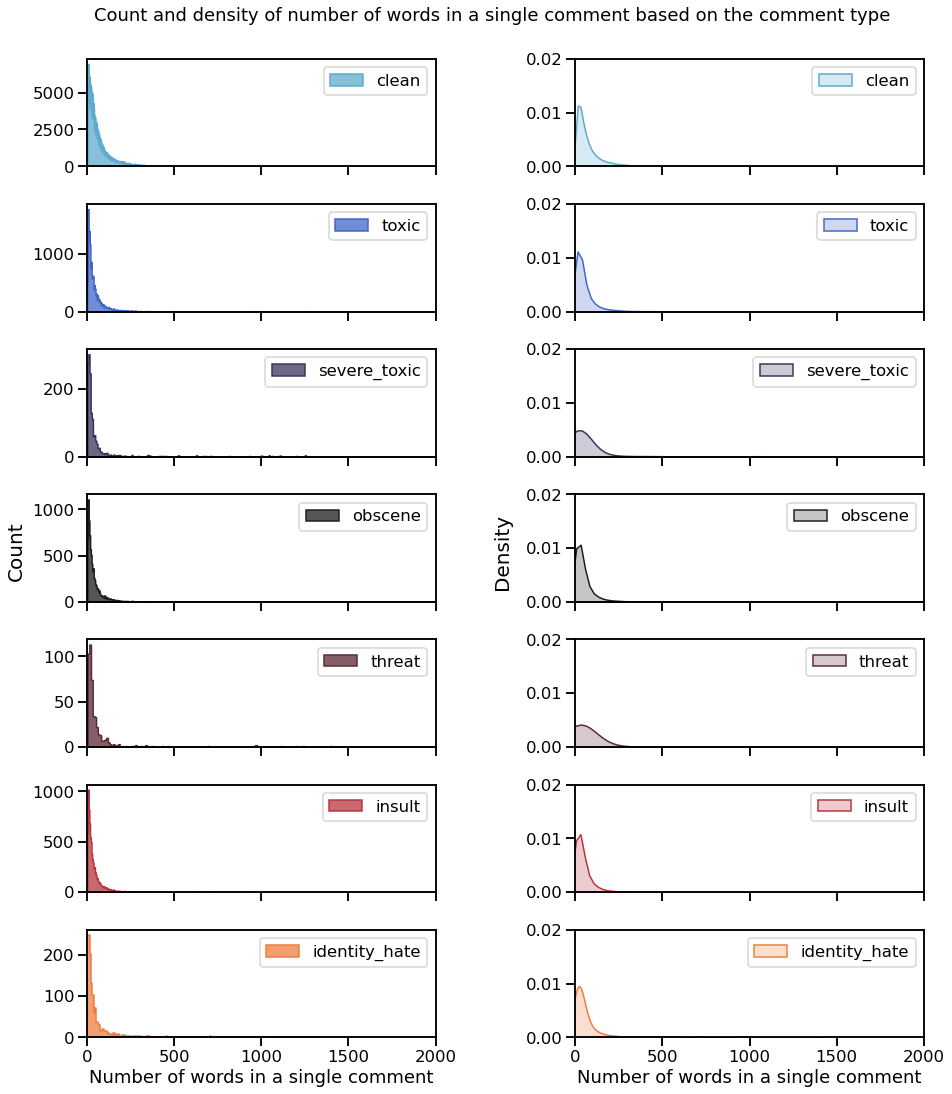

In [12]:
title = 'Count and density of number of words in a single comment based on the comment type'
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
plt.subplots_adjust(hspace=0.35, wspace=0.4)
fig.suptitle(title, fontsize=18, y=0.92)
colors = sns.color_palette("icefire", 7)

sns.histplot(data=train_df[train_df['num_tags']==0], x='word_count', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=train_df[train_df['num_tags']==0]['word_count'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,2000)
ax[0, 1].set_ylim(0,0.02)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in train_df.columns[2:8]:
    
    sns.histplot(data=train_df[train_df[col]==1], x='word_count', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=train_df[train_df[col]==1]['word_count'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,2000)
    ax[row_count, 1].set_ylim(0,0.02)
    ax[row_count, 0].set_xlabel('Number of words in a single comment')
    ax[row_count, 1].set_xlabel('Number of words in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    
    row_count += 1   
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.51, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20) 
plt.show()

Severe toxic and threat comment types tend to include greater number of words compared to non-toxic and other toxic categories.

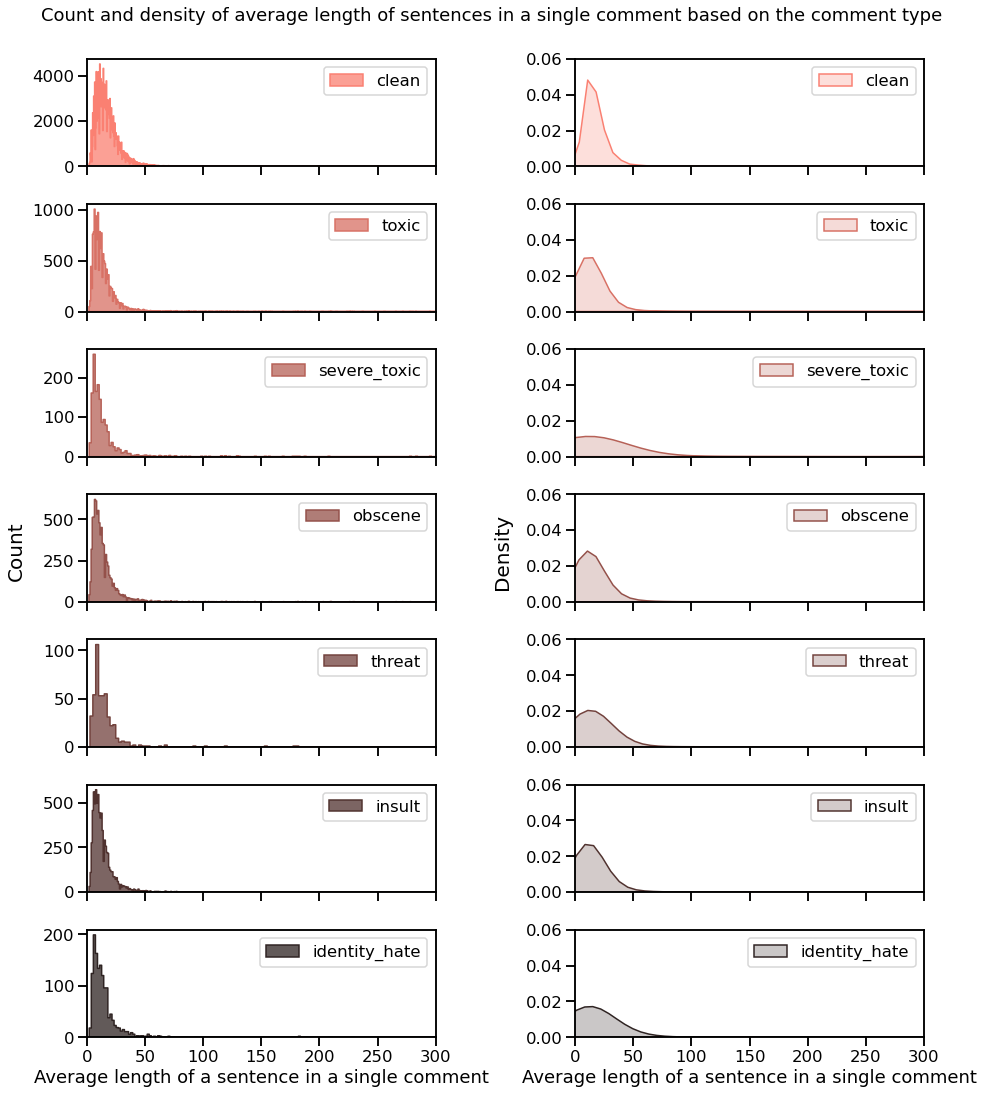

In [13]:
title = 'Count and density of average length of sentences in a single comment based on the comment type'

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
fig.suptitle(title, fontsize=18, y=0.92)
fig.subplots_adjust(hspace=0.35, wspace=0.4)
colors = sns.color_palette("dark:salmon_r", 7)

sns.histplot(data=train_df[train_df['num_tags']==0], x='avg_word_sent', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=train_df[train_df['num_tags']==0]['avg_word_sent'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,300)
ax[0, 1].set_ylim(0,0.06)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in train_df.columns[2:8]:
    
    sns.histplot(data=train_df[train_df[col]==1], x='avg_word_sent', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=train_df[train_df[col]==1]['avg_word_sent'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,300)
    ax[row_count, 1].set_ylim(0,0.06)
    ax[row_count, 0].set_xlabel('Average length of a sentence in a single comment')
    ax[row_count, 1].set_xlabel('Average length of a sentence in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    
    row_count += 1
    
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.51, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20) 
plt.show()

In general, average length of a sentence in toxic categories is longer than the non-toxic comments. Specifically, severe toxic, identity hate and threat sentences are longer than the other categories.

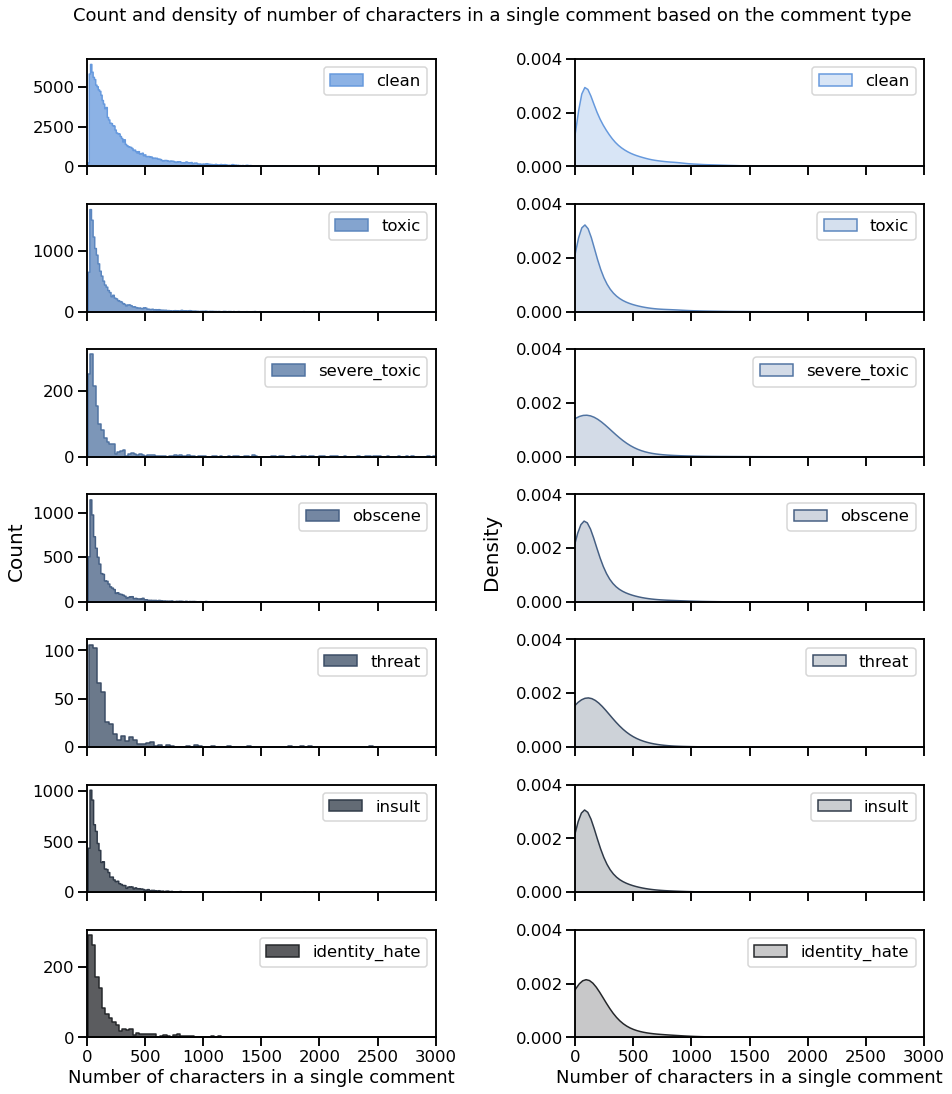

In [14]:
title = 'Count and density of number of characters in a single comment based on the comment type'

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
fig.suptitle(title, fontsize=18, y=0.92)
fig.subplots_adjust(hspace=0.35, wspace=0.4)
colors = sns.dark_palette("#69d", 7, reverse=True)

sns.histplot(data=train_df[train_df['num_tags']==0], x='char_count', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=train_df[train_df['num_tags']==0]['char_count'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,3000)
ax[0, 1].set_ylim(0,0.004)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in train_df.columns[2:8]:
    
    sns.histplot(data=train_df[train_df[col]==1], x='char_count', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=train_df[train_df[col]==1]['char_count'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,3000)
    ax[row_count, 1].set_ylim(0,0.004)
    ax[row_count, 0].set_xlabel('Number of characters in a single comment')
    ax[row_count, 1].set_xlabel('Number of characters in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    
    row_count += 1
    
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20) 

plt.show()

Nnumber of characters of a sentence in tidentity hate, threat and severe toxic categories tend to be larger compared to non-toxic and other toxic categories.

I am curious to know if there is any correlation between the number of tags and word and sentence counts! Let's figure it out.

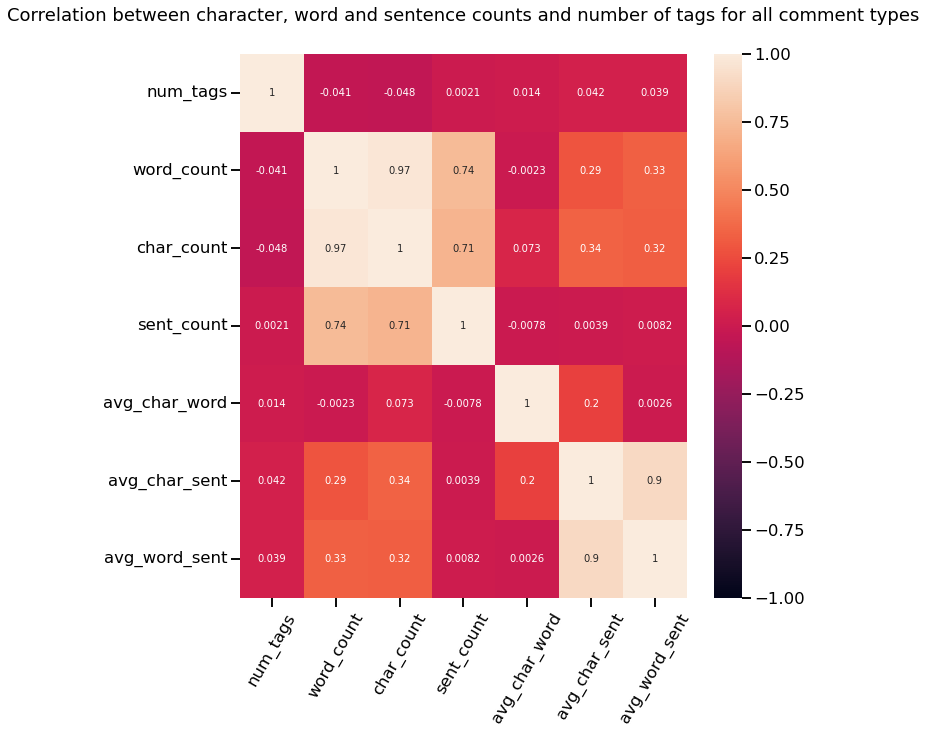

In [15]:
corr = train_df.iloc[:, -7:].corr()
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.tick_params(axis='y', rotation=0)
heatmap.tick_params(axis='x', rotation=60)
heatmap.set_title('Correlation between character, word and sentence counts and number of tags for all comment types'
                  , y =1.05)
plt.show()

There is no correlation between the number of tags and the other features!

### Word Cloud

Now, I visualize the the text information for each category. A nice way to visualize the text information is using a word cloud.

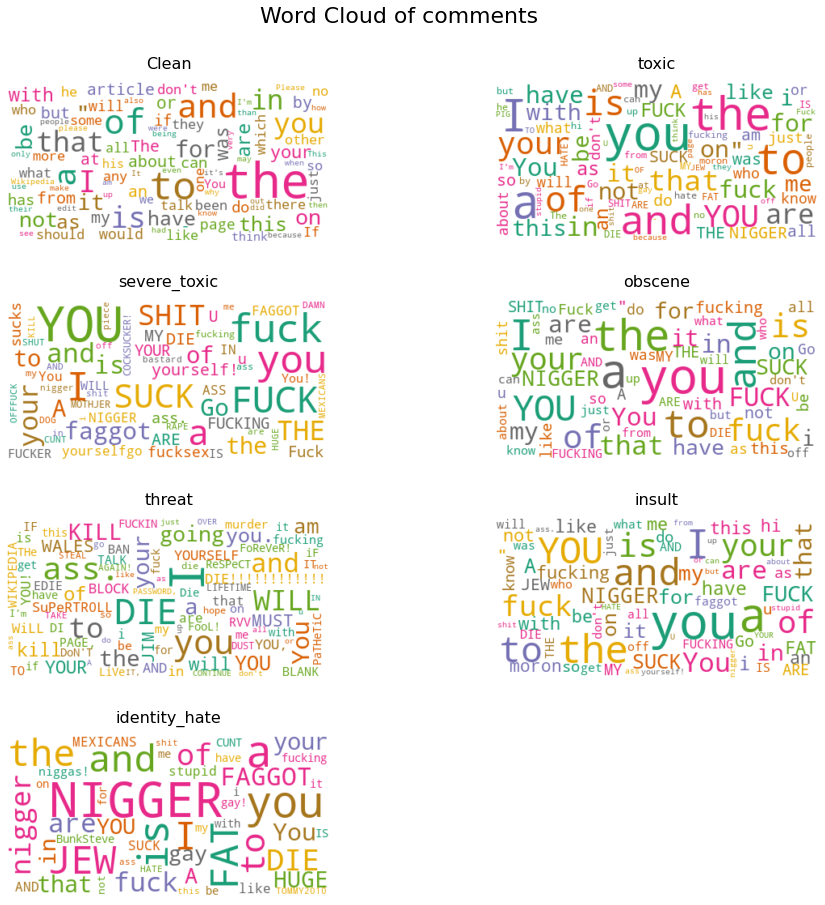

In [16]:
cloud = WordCloud(max_font_size=60, min_font_size=10, max_words=100, background_color='white', 
               colormap='Dark2', repeat=False, random_state=10, contour_width=0.1,
            contour_color='black',mode='RGB', collocations=False)

fig = plt.figure(figsize=(15,15))

# Non-toxic comments
text = list(' '.join(train_df[train_df.num_tags == 0]['comment_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(4, 2, 1)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clean', fontsize=16, y=1.05)
  

# Toxic comments
i = 2
for col in train_df.columns[2:8]:
    
    ax = fig.add_subplot(4, 2, i)
    
    text = list(' '.join(train_df[train_df[col] != 0]['comment_text']).split())
    counter = Counter(text)
    most_common = counter.most_common()

    frequency = {}
    for word, count in most_common[:100]:
        frequency[word] = count
        
    wordcloud = cloud.generate_from_frequencies(frequency)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.title(col, fontsize=16, y=1.05)
    plt.suptitle('Word Cloud of comments', fontsize=22, y=0.95)
    i += 1
    
fig.subplots_adjust(hspace=0.35, wspace=0.4)
plt.show()

The wordcloud representation shows that I need to perform text prepocessing. I need to remove unnecessary words, like punctutation, white spaces and stop words. Also, lemmatization (converting a word to its base form) and lower casing are essential.

## Cleaning and Preprocessing of Text

In this section, I define functions to perform text preprocessing and cleaning and test the functions, too.

In [17]:
# Removing html tags

def strip_html_tags(text):
    soup = bs(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

train['comment_text'][:5].apply(strip_html_tags)

0    Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I ...
1                                         D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
2    Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits in...
3    "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of...
4                                                                                      You, sir, are my hero. Any chance you remember what page that's on?
Name: comment_text, dtype: object

In [18]:
# Removing special characters

def special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, ' ', text)
    return text

train['comment_text'][:5].apply(special_characters)

0    Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted  They weren t vandalisms  just closure on some GAs after I ...
1                                         D aww  He matches this background colour I m seemingly stuck with  Thanks    talk         January           UTC 
2    Hey man  I m really not trying to edit war  It s just that this guy is constantly removing relevant information and talking to me through edits in...
3     \nMore\nI can t make any real suggestions on improvement   I wondered if the section statistics should be later on  or a subsection of   types of...
4                                                                                      You  sir  are my hero  Any chance you remember what page that s on 
Name: comment_text, dtype: object

In [19]:
# Lemmatization

nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

train['comment_text'][:5].apply(lemmatize_text)


0    Explanation \n why the edit make under my username Hardcore Metallica Fan be revert ? they be not vandalism , just closure on some gas after I vot...
1                                 D'aww ! he match this background colour I be seemingly stuck with . thank .   ( talk ) 21:51 , January 11 , 2016 ( UTC )
2    hey man , I be really not try to edit war . it be just that this guy be constantly remove relevant information and talk to I through edit instead ...
3    " \n More \n I can not make any real suggestion on improvement - I wonder if the section statistic should be later on , or a subsection of " " typ...
4                                                                                  you , sir , be my hero . any chance you remember what page that be on ?
Name: comment_text, dtype: object

In [20]:
# Remove stop words

stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')

def remove_stopwords(text):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    text = ' '.join([token for token in tokens if token.lower() not in stopwords])
    return text

remove_stopwords(train['comment_text'][0])

"Explanation edits made username Hardcore Metallica Fan reverted ? ' vandalisms , closure GAs voted New York Dolls FAC. please ' remove template talk page since ' retired now.89.205.38.27"

In [21]:
# Case conversion

def text_conversion(text, case = 'lower'):
    if case == 'lower':
        return text.lower()
    elif case == 'upper':
        return text.upper()
    elif case == 'title':
        return text.title()
    else:
        return text
    
text_conversion(train['comment_text'][0], case='lower')

"explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

In [29]:
import time

starttime = time.time()

for i in range(0, len(train_df), 10000):
    comment_df = train_df[i:i+10000]
    train_df.loc[i:i+10000,['clean_text']] = comment_df['comment_text'].apply(special_characters). \
                                apply(lemmatize_text).apply(remove_stopwords).apply(text_conversion)
          
    time.sleep(2)
    
print('The text preprocessing took {} seconds'.format(time.time() - starttime))

The text preprocessing took 2145.557512283325 seconds


In [30]:
train_df[['comment_text', 'clean_text']].head()

comment_text                                                                                                                                             clean_text
0  Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I ...  explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since...
1                                       D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                     aww match background colour seemingly stuck thank talk january utc
2  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits in...                hey man really not try edit war guy constantly remove relevant information talk edit instead talk page seem care formatting actual info
3  "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of...  make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format...
4                                                                                    You, sir, are my hero. Any chance you remember what page that's on?                                                                                                                          sir hero chance remember page

In [31]:
train_df[['comment_text', 'clean_text']].tail()

comment_text                                                                                                                                             clean_text
159566  ":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you f...  second time ask view completely contradict coverage reliable source anyone care feel even give consistent argument opening suppose mention signifi...
159567                                                  You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page.  128.61.19.93                                                                                                                   ashamed horrible thing put talk page
159568                                                                    Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.                                                                                         spitzer umm no actual article prostitution ring crunch captain
159569                                   And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.                                                                                                look like actually put speedy first version delete look
159570  "\nAnd ... I really don't think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" g...                                               really think understand come idea bad right away kind community go bad idea go away instead help rewrite

### Word Cloud Representation After Text Preprocessing

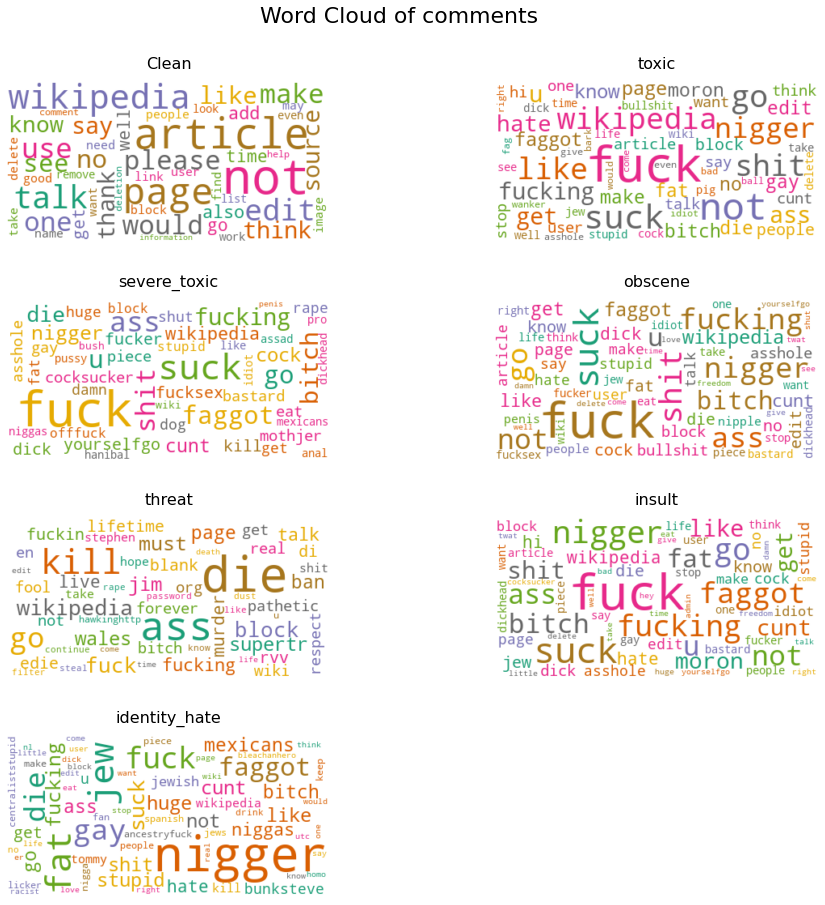

In [32]:
cloud = WordCloud(max_font_size=60, min_font_size=10, max_words=100, background_color='white', 
               colormap='Dark2', repeat=False, random_state=10, contour_width=0.1,
            contour_color='black',mode='RGB', collocations=False)

fig = plt.figure(figsize=(15,15))

# Non-toxic comments
text = list(' '.join(train_df[train_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(4, 2, 1)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clean', fontsize=16, y=1.05)
  

# Toxic comments
i = 2
for col in train_df.columns[2:8]:
    
    ax = fig.add_subplot(4, 2, i)
    
    text = list(' '.join(train_df[train_df[col] != 0]['clean_text']).split())
    counter = Counter(text)
    most_common = counter.most_common()

    frequency = {}
    for word, count in most_common[:100]:
        frequency[word] = count
        
    wordcloud = cloud.generate_from_frequencies(frequency)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.title(col, fontsize=16, y=1.05)
    plt.suptitle('Word Cloud of comments', fontsize=22, y=0.95)
    i += 1
    
fig.subplots_adjust(hspace=0.35, wspace=0.4)
plt.show()

It seems that the text cleaning and preprocessing worked well.
<br> Now, let's look at the most common words and their counts in the text.

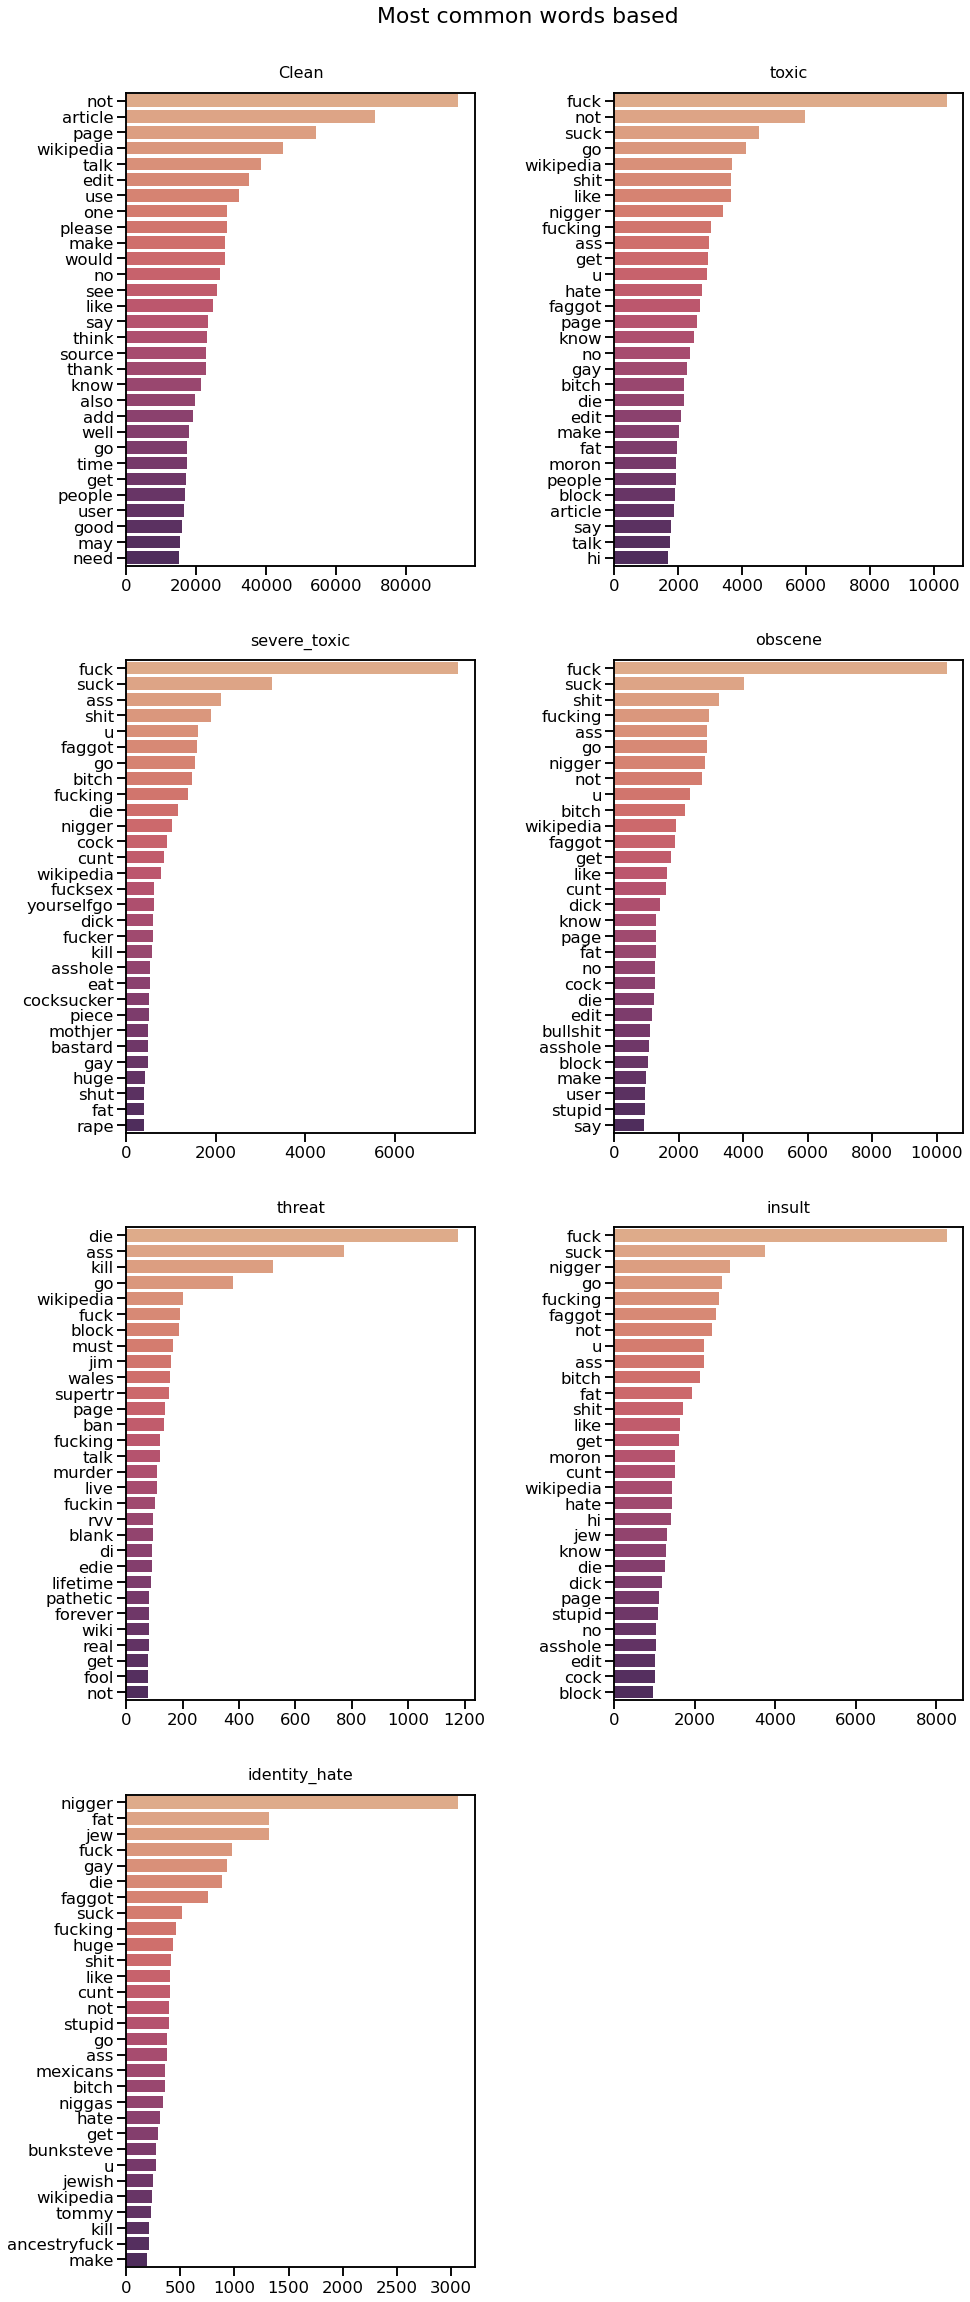

In [33]:
fig = plt.figure(figsize=(15,40))

# Non-toxic comments
text = list(' '.join(train_df[train_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

x, y = [], []
for word, count in most_common[:30]:
    y.append(word)
    x.append(count)

ax = fig.add_subplot(4, 2, 1)
sns.barplot(x=x, y=y, palette='flare')
plt.title('Clean', fontsize=16, y=1.02)
  

# Toxic comments
i = 2
for col in train_df.columns[2:8]:
    
    ax = fig.add_subplot(4, 2, i)
    
    text = list(' '.join(train_df[train_df[col] != 0]['clean_text']).split())
    counter = Counter(text)
    most_common = counter.most_common()

    x, y = [], []
    for word, count in most_common[:30]:
        y.append(word)
        x.append(count)
          
    sns.barplot(x=x, y=y, palette='flare')
    plt.title(col, fontsize=16, y=1.02)
    i += 1

plt.suptitle('Most common words based ', fontsize=22, y=0.91)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
plt.show()

## EDA Based on Two Non-toxic and Toxic Groups

In the first part of this preject, I will consider only two categories for comments: non-toxic and toxic. Therefore, let's perform EDA based on only these two categories.

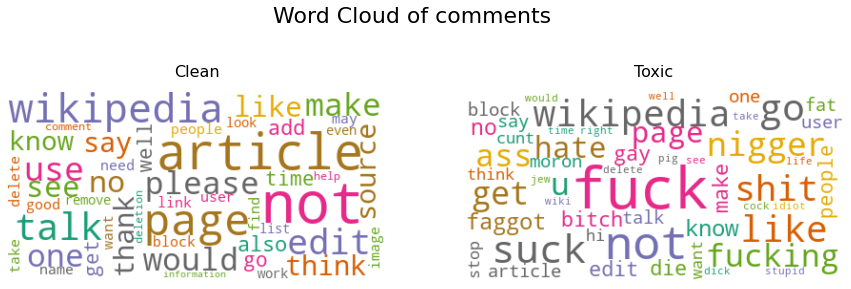

In [34]:
cloud = WordCloud(max_font_size=60, min_font_size=10, max_words=200, background_color='white', 
               colormap='Dark2', repeat=False, contour_color='black',mode='RGB', 
                collocations=False, random_state=10)

fig = plt.figure(figsize=(15,6))

# Non-toxic comments
text = list(' '.join(train_df[train_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clean', fontsize=16, y=1.05)
  

# Toxic comments
text = list(' '.join(train_df[train_df.num_tags != 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Toxic', fontsize=16, y=1.05)
plt.suptitle('Word Cloud of comments', fontsize=22, y=0.92)
    
plt.show()

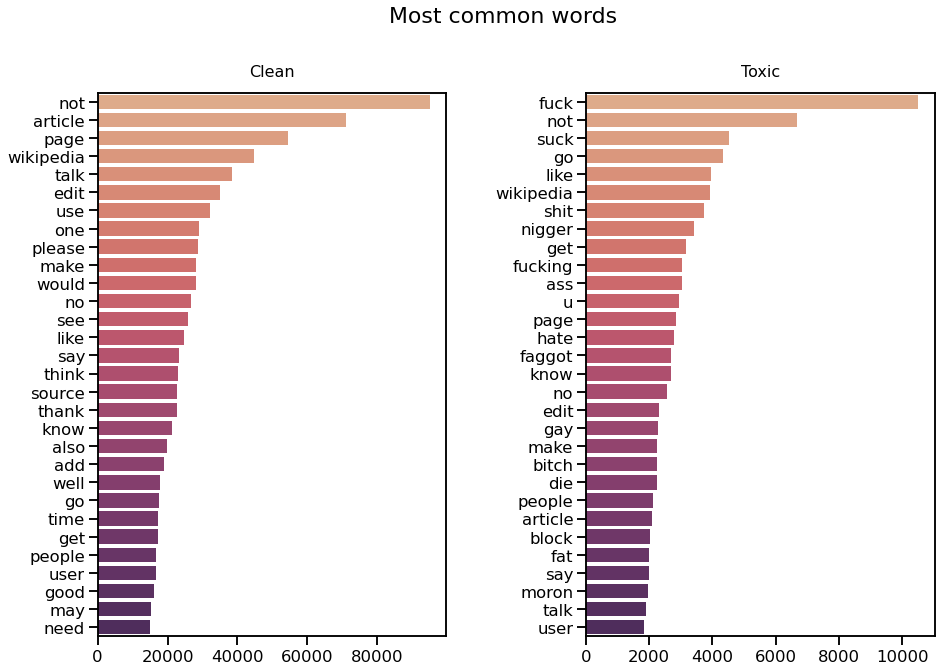

In [35]:
fig = plt.figure(figsize=(15,10))

# Non-toxic comments
text = list(' '.join(train_df[train_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

x, y = [], []
for word, count in most_common[:30]:
    y.append(word)
    x.append(count)

ax = fig.add_subplot(1, 2, 1)
sns.barplot(x=x, y=y, palette='flare')
plt.title('Clean', fontsize=16, y=1.02)
  

# Toxic comments
text = list(' '.join(train_df[train_df.num_tags != 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

x, y = [], []
for word, count in most_common[:30]:
    y.append(word)
    x.append(count)

ax = fig.add_subplot(1, 2, 2)
sns.barplot(x=x, y=y, palette='flare')
plt.title('Toxic', fontsize=16, y=1.02)
plt.suptitle('Most common words', fontsize=22, y=1)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
    
plt.show()

## Text Vectorizer

### Bag of Words (BOW) Model

### Unigram

In [37]:
vectorizer = CountVectorizer()
text_matrix = vectorizer.fit_transform(train_df.clean_text)
count_array = text_matrix.toarray()
bow_uni_df = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names())
bow_uni_df.index = train_df.index
bow_uni_df.head()

aa  aaa  aaaa  aaaaa  aaaaaaaa  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany  aaaaaaaaaah  aaaaaaaaaahhhhhhhhhhhhhh  aaaaaaaaadm  aaaaaaaaaq  aaaaaaaacfo  aaaaaaaaczy  aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh  aaaaaaaari  aaaaaaaayui  aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh  aaaaaaw  aaaaah  aaaah  aaaannnnyyyywwwwhhhheeeerrrreeee  aaaawwww  aaaboyz  aaage  aaaghh  aaah  aaahhh  aaai  aaajade  aaand  aaarrrgggh  aaaww  aab  aaba  aaberg  aabove  aac  aacargo  aacd  \
0   0    0     0      0         0                                                                         0            0                         0            0           0            0            0                                          0           0            0                                0        0       0      0                                 0         0        0      0       0     0       0     0        0      0           0      0    0     0       0       0    0        0     0   
1   0    0     0      0         0                                                                         0            0                         0            0           0            0            0                                          0           0            0                                0        0       0      0                                 0         0        0      0       0     0       0     0        0      0           0      0    0     0       0       0    0        0     0   
2   0    0     0      0         0                                                                         0            0                         0            0           0            0            0                                          0           0            0                                0        0       0      0                                 0         0        0      0       0     0       0     0        0      0           0      0    0     0       0       0    0        0     0   
3   0    0     0      0         0                                                                         0            0                         0            0           0            0            0                                          0           0            0                                0        0       0      0                                 0         0        0      0       0     0       0     0        0      0           0      0    0     0       0       0    0        0     0   
4   0    0     0      0         0                                                                         0            0                         0            0           0            0            0                                          0           0            0                                0        0       0      0                                 0         0        0      0       0     0       0     0        0      0           0      0    0     0       0       0    0        0     0   

   aachen  aachi  aacs  aad  aadd  aademia  aadil  aadmi  aadministrators  aadu  aae  aaet  ...  zwoiw  zwol  zwolle  zworykin  zwr  zwyke  zx  zxcvbnm  zxpdlmodo  zxyejaeo  zyan  zyar  zybez  zycznej  zydeco  zydyaon  zyeno  zygarchy  zygon  zygote  zyklon  zyl  zynga  zythe  zyuranger  zyx  zyxoas  zyxw  zyzzyxrd  zyzzzzy  zyzzzzzy  zz  zzaroc  zzem  zzet  zzm  zzteu  zzuuzz  zzy  zzyzwicz  zzz  zzzz  zzzzz  zzzzzzz  zzzzzzzzzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz  \
0       0      0     0    0     0        0      0      0                0     0    0     0  ...      0     0       0         0    0      0   0        0          0         0     0     0      0        0       0        0      0         0      0       0       0    0      0      0          0    0       0     0         0        0         0   0       0     0     0    0      0       0    0         0    0     0      0        0                  0                      0                               0   
1       0      0     0    0 

Countvectorizer creates a dataframe consisting of 157328 features. In order to remove the meaningless words and less frequent ones and also decrease the number of features, we can specify the number of features. Let's try it.

In [40]:
n_features = 20000
vectorizer = CountVectorizer(max_features=n_features)
text_matrix = vectorizer.fit_transform(train_df.clean_text)
count_array = text_matrix.toarray()
bow_uni_df = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names())
bow_uni_df.index = train_df.index
bow_uni_df.head()

aa  aaa  aaliyah  aap  aardvark  aaron  aave  ab  aba  abad  abandon  abandonment  abbas  abbey  abbott  abbottabad  abbreviate  abbreviation  abc  abcnew  abd  abduct  abduction  abdul  abdullah  abe  abel  aberration  abhira  abhishek  abhor  abhorrent  abi  abide  ability  abit  abject  abkhazia  able  abnormal  aboard  abolish  abomination  aboriginal  aborigine  abortion  abou  abound  aboutus  abraham  ...  zealous  zebedee  zebra  zedong  zeitgeist  zelda  zen  zeno  zeppelin  \
0   0    0        0    0         0      0     0   0    0     0        0            0      0      0       0           0           0             0    0       0    0       0          0      0         0    0     0           0       0         0      0          0    0      0        0     0       0         0     0         0       0        0            0           0          0         0     0       0        0        0  ...        0        0      0       0          0      0    0     0         0   
1   0    0        0    0         0      0     0   0    0     0        0            0      0      0       0           0           0             0    0       0    0       0          0      0         0    0     0           0       0         0      0          0    0      0        0     0       0         0     0         0       0        0            0           0          0         0     0       0        0        0  ...        0        0      0       0          0      0    0     0         0   
2   0    0        0    0         0      0     0   0    0     0        0            0      0      0       0           0           0             0    0       0    0       0          0      0         0    0     0           0       0         0      0          0    0      0        0     0       0         0     0         0       0        0            0           0          0         0     0       0        0        0  ...        0        0      0       0          0      0    0     0         0   
3   0    0        0    0         0      0     0   0    0     0        0            0      0      0       0           0           0             0    0       0    0       0          0      0         0    0     0           0       0         0      0          0    0      0        0     0       0         0     0         0       0        0            0           0          0         0     0       0        0        0  ...        0        0      0       0          0      0    0     0         0   
4   0    0        0    0         0      0     0   0    0     0        0            0      0      0       0           0           0             0    0       0    0       0          0      0         0    0     0           0       0         0      0          0    0      0        0     0       0         0     0         0       0        0            0           0          0         0     0       0        0        0  ...        0        0      0       0          0      0    0     0         0   

   zereshk  zero  zervas  zeta  zeus  zh  zhang  zhanzhao  zheng  zhi  zhu  zilla  zillion  zimbabwe  zimmerman  zinc  zine  zion  zionism  zionist  zionists  zip  zlykinskyja  zodiac  zoe  zombie  zone  zoo  zoological  zoom  zora  zoroastrian  zoroastrianism  zu  zuck  zuckerberg  zulu  zundel  zurich  zzuuzz  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz  
0        0     0       0     0     0   0      0         0      0    0    0      0        0         0          0     0     0     0        0        0         0    0            0       0    0       0     0    0           0     0     0            0               0   0     0           0     0       0       0       0                                                                                                                                                      0   
1        0     0       0     0     0   0      0         0      0    0    0      0        0         0    

In [41]:
n_features = 10000
vectorizer = CountVectorizer(max_features=n_features)
text_matrix = vectorizer.fit_transform(train_df.clean_text)
count_array = text_matrix.toarray()
bow_uni_df = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names())
bow_uni_df.index = train_df.index
bow_uni_df.head()

aa  aap  aaron  ab  abandon  abbey  abbreviate  abbreviation  abc  abd  abdul  abhira  abide  ability  able  abolish  aboriginal  abortion  abraham  abroad  absence  absent  absolute  absolutely  absorb  abstain  abstract  absurd  absurdity  abu  abundance  abundantly  abuse  abuser  abusing  abusive  ac  academia  academic  academy  acc  accelerate  acceleration  accent  accept  acceptable  acceptance  accepted  access  accessdate  ...  yehovah  yell  yellow  yemen  yep  yepes  yer  yes  \
0   0    0      0   0        0      0           0             0    0    0      0       0      0        0     0        0           0         0        0       0        0       0         0           0       0        0         0       0          0    0          0           0      0       0        0        0   0         0         0        0    0           0             0       0       0           0           0         0       0           0  ...        0     0       0      0    0      0    0    0   
1   0    0      0   0        0      0           0             0    0    0      0       0      0        0     0        0           0         0        0       0        0       0         0           0       0        0         0       0          0    0          0           0      0       0        0        0   0         0         0        0    0           0             0       0       0           0           0         0       0           0  ...        0     0       0      0    0      0    0    0   
2   0    0      0   0        0      0           0             0    0    0      0       0      0        0     0        0           0         0        0       0        0       0         0           0       0        0         0       0          0    0          0           0      0       0        0        0   0         0         0        0    0           0             0       0       0           0           0         0       0           0  ...        0     0       0      0    0      0    0    0   
3   0    0      0   0        0      0           0             0    0    0      0       0      0        0     0        0           0         0        0       0        0       0         0           0       0        0         0       0          0    0          0           0      0       0        0        0   0         0         0        0    0           0             0       0       0           0           0         0       0           0  ...        0     0       0      0    0      0    0    0   
4   0    0      0   0        0      0           0             0    0    0      0       0      0        0     0        0           0         0        0       0        0       0         0           0       0        0         0       0          0    0          0           0      0       0        0        0   0         0         0        0    0           0             0       0       0           0           0         0       0           0  ...        0     0       0      0    0      0    0    0   

   yesterday  yet  yiddish  yield  yo  yoga  yooo  york  yorker  yorkshire  youbollocks  youcaltlas  young  yourselfgo  youth  youtube  yr  ytmnd  yu  yugoslav  yugoslavia  yup  za  ze  zealand  zealot  zero  zeus  zimmerman  zinc  zion  zionism  zionist  zionists  zoe  zombie  zone  zoo  zoom  zora  zuck  zuckerberg  
0          0    0        0      0   0     0     0     1       0          0            0           0      0           0      0        0   0      0   0         0           0    0   0   0        0       0     0     0          0     0     0        0        0         0    0       0     0    0     0     0     0           0  
1          0    0        0      0   0     0     0     0       0          0            0           0      0           0      0        0   0      0   0         0           0    0   0   0        0       0     0     0          0     0     0        0        0         0    0       0     0    0     0     0     0           0  
2          0    0        0      0   0     0  

Therefore, we can tune the number of features in the next step by creating and testing our models.

## BOW and Ngrams

Now, I perform bigram and trigram on the dataset to examine the output.

### Bigram

In [42]:
n_features = 10000
vectorizer = CountVectorizer(max_features=n_features, ngram_range = (2,2))
text_matrix = vectorizer.fit_transform(train_df.clean_text)
count_array = text_matrix.toarray()
bow_bi_df = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names())
bow_bi_df.index = train_df.index
bow_bi_df.head()

ability create  able edit  able find  able get  able help  able make  able see  able use  absolutely no  absolutely not  absolutely nothing  abuse admin  abuse power  abuse wikipedia  abuse wikipedian  abusing power  academic journal  academic source  accept apology  accept appropriate  accept copyright  accept not  accept notable  acceptable addition  acceptable fair  acceptable source  acceptable use  access deneid  accord article  accord propose  accord wikipedia  accord wp  \
0               0          0          0         0          0          0         0         0              0               0                   0            0            0                0                 0              0                 0                0               0                   0                 0           0               0                    0                0                  0               0              0               0               0                 0          0   
1               0          0          0         0          0          0         0         0              0               0                   0            0            0                0                 0              0                 0                0               0                   0                 0           0               0                    0                0                  0               0              0               0               0                 0          0   
2               0          0          0         0          0          0         0         0              0               0                   0            0            0                0                 0              0                 0                0               0                   0                 0           0               0                    0                0                  0               0              0               0               0                 0          0   
3               0          0          0         0          0          0         0         0              0               0                   0            0            0                0                 0              0                 0                0               0                   0                 0           0               0                    0                0                  0               0              0               0               0                 0          0   
4               0          0          0         0          0          0         0         0              0               0                   0            0            0                0                 0              0                 0                0               0                   0                 0           0               0                    0                0                  0               0              0               0               0                 0          0   

   accordance wikipedia  account avoid  account block  account create  account creation  account edit  account free  account make  account name  account not  account please  account use  account user  account wikipedia  accurate information  accurate not  accurate verifiable  accusation make  ...  wrong person  wrong place  wrong please  wrong say  wrong way  wrong wikipedia  wrong wrong  wtc mongo  www google  www youtube  yaaa bitch  yaaaa ah  yahoo com  yeah know  yeah right  yeah yeah  \
0                     0              0              0               0                 0             0             0             0             0            0               0            0             0                  0                     0             0                    0                0  ...             0            0             0          0          0                0            0          0           0            0           0         0          0          0           0          0   
1                     0              0              0               0           

### Trigram

In [43]:
n_features = 10000
vectorizer = CountVectorizer(max_features=n_features, ngram_range = (3,3))
text_matrix = vectorizer.fit_transform(train_df.clean_text)
count_array = text_matrix.toarray()
bow_bi_df = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names())
bow_bi_df.index = train_df.index
bow_bi_df.head()

abide wikipedia policy  ability create article  ability customize appearance  ability rename page  ability upload image  abkhazia south ossetia  able edit page  aboutus talk contribs  absolutely no reason  absolutely no sense  abuse account creation  abuse admin power  abuse admin privilege  abuse editing privilege  abuse multiple account  abuse wikipedian dickhead  abusing power proof  acalamari archive acalamari  accept appropriate article  accept copyright text  accept notable feel  \
0                       0                       0                             0                    0                     0                       0               0                      0                     0                    0                       0                  0                      0                        0                       0                          0                    0                            0                           0                      0                    0   
1                       0                       0                             0                    0                     0                       0               0                      0                     0                    0                       0                  0                      0                        0                       0                          0                    0                            0                           0                      0                    0   
2                       0                       0                             0                    0                     0                       0               0                      0                     0                    0                       0                  0                      0                        0                       0                          0                    0                            0                           0                      0                    0   
3                       0                       0                             0                    0                     0                       0               0                      0                     0                    0                       0                  0                      0                        0                       0                          0                    0                            0                           0                      0                    0   
4                       0                       0                             0                    0                     0                       0               0                      0                     0                    0                       0                  0                      0                        0                       0                          0                    0                            0                           0                      0                    0   

   accept notable first  accept notable guideline  accept notable indicate  accept notable specific  accept notable think  accept notable well  accept unblock request  acceptable addition like  acceptable fair use  acceptable use wikipedia  access deneid access  access read encyclopedia  accord csd involve  accord propose deletion  accord wikipedia guideline  accord wikipedia policy  accordance deletion policy  accordance fair use  accordance policy would  accordance wikipedia block  \
0                     0                         0                        0                        0                     0                    0                       0                         0                    0                         0                     0                         0                   0                        0                           0                        0                           0                    0                        0                           0   
1                     0                     

## TF-IDF Text-Vectorizer

In [44]:
tfidf = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True)
train_tfidf = tfidf.fit_transform(train_df['clean_text'])
tfidf_array = train_tfidf.toarray()
train_tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf.get_feature_names())
train_tfidf_df.head()

aa  aaa  aap  aardvark  aaron   ab  aba  abandon  abandonment  abbas  abbey  abbott  abbreviate  abbreviation  abc  abcnew  abd  abduct  abduction  abdul  abdullah  abe  abel  aberration  abhishek  abhor  abhorrent  abide  ability  abit  abject  abkhazia  able  abnormal  aboard  abolish  abomination  aboriginal  abort  abortion  abound  abraham  abrahamic  abrams  abrasive  abridge  abroad  abrupt  abruptly  abs  ...  zad  zagreb  zakir  zap  zappa   ze  zeal  zealand  zealot  zealous  \
0  0.0  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0     0.0  0.0     0.0        0.0    0.0       0.0  0.0   0.0         0.0       0.0    0.0        0.0    0.0      0.0   0.0     0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0    0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0       0.0  0.0  ...  0.0     0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0   
1  0.0  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0     0.0  0.0     0.0        0.0    0.0       0.0  0.0   0.0         0.0       0.0    0.0        0.0    0.0      0.0   0.0     0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0    0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0       0.0  0.0  ...  0.0     0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0   
2  0.0  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0     0.0  0.0     0.0        0.0    0.0       0.0  0.0   0.0         0.0       0.0    0.0        0.0    0.0      0.0   0.0     0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0    0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0       0.0  0.0  ...  0.0     0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0   
3  0.0  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0     0.0  0.0     0.0        0.0    0.0       0.0  0.0   0.0         0.0       0.0    0.0        0.0    0.0      0.0   0.0     0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0    0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0       0.0  0.0  ...  0.0     0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0   
4  0.0  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0     0.0  0.0     0.0        0.0    0.0       0.0  0.0   0.0         0.0       0.0    0.0        0.0    0.0      0.0   0.0     0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0    0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0       0.0  0.0  ...  0.0     0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0   

   zebedee  zeitgeist  zelda  zen  zeno  zeppelin  zereshk  zero  zeta  zeus   zh  zhang  zhanzhao  zillion  zimbabwe  zimmerman  zinc  zine  zion  zionism  zionist  zionists  zip  zodiac  zoe  zombie  zomg  zone  zoo  zoological  zoology  zoom  zootalk  zora  zoroastrian  zoroastrianism   zu  zulu  zurich  zzuuzz  
0      0.0        0.0    0.0  0.0   0.0       0.0      0.0   0.0   0.0   0.0  0.0    0.0       0.0      0.0       0.0        0.0   0.0   0.0   0.0      0.0      0.0       0.0  0.0     0.0  0.0     0.0   0.0   0.0  0.0         0.0      0.0   0.0      0.0   0.0          0.0             0.0  0.0   0.0     0.0     0.0  
1      0.0        0.0    0.0  0.0   0.0       0.0      0.0   0.0   0.0   0.0  0.0    0.0       0.0      0.0       0.0        0.0   0.0   0.0   0.0      0.0      0.0       0.0  0.0     0.0  0.0     0.0   0.0   0.0  0.0         0.0      0.0   0.0      0.0   0.0          0.0             0.0  0.0   0.0     0.0     0.0  
2      0.0        0.0    0.0  0.0   0.0       0.0      0.0   0.0   

In [45]:
n_features = 15000
tfidf = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True, max_features=n_features)
train_tfidf = tfidf.fit_transform(train_df['clean_text'])
tfidf_array = train_tfidf.toarray()
train_tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf.get_feature_names())
train_tfidf_df.head()

aa  aap  aardvark  aaron   ab  aba  abandon  abandonment  abbas  abbey  abbott  abbreviate  abbreviation  abc  abd  abduction  abdul  abdullah  abe  abhishek  abhorrent  abide  ability  abit  abkhazia  able  abnormal  aboard  abolish  abomination  aboriginal  abortion  abound  abraham  abrahamic  abrams  abrasive  abridge  abroad  abrupt  abs  absence  absent  absolute  absolutely  absolutly  absorb  abstain  abstract  abstraction  ...  yuan  yuber  yue  yugo  yugoslav  yugoslavia  yup  \
0  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0  0.0        0.0    0.0       0.0  0.0       0.0        0.0    0.0      0.0   0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0  0.0      0.0     0.0       0.0         0.0        0.0     0.0      0.0       0.0          0.0  ...   0.0    0.0  0.0   0.0       0.0         0.0  0.0   
1  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0  0.0        0.0    0.0       0.0  0.0       0.0        0.0    0.0      0.0   0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0  0.0      0.0     0.0       0.0         0.0        0.0     0.0      0.0       0.0          0.0  ...   0.0    0.0  0.0   0.0       0.0         0.0  0.0   
2  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0  0.0        0.0    0.0       0.0  0.0       0.0        0.0    0.0      0.0   0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0  0.0      0.0     0.0       0.0         0.0        0.0     0.0      0.0       0.0          0.0  ...   0.0    0.0  0.0   0.0       0.0         0.0  0.0   
3  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0  0.0        0.0    0.0       0.0  0.0       0.0        0.0    0.0      0.0   0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0  0.0      0.0     0.0       0.0         0.0        0.0     0.0      0.0       0.0          0.0  ...   0.0    0.0  0.0   0.0       0.0         0.0  0.0   
4  0.0  0.0       0.0    0.0  0.0  0.0      0.0          0.0    0.0    0.0     0.0         0.0           0.0  0.0  0.0        0.0    0.0       0.0  0.0       0.0        0.0    0.0      0.0   0.0       0.0   0.0       0.0     0.0      0.0          0.0         0.0       0.0     0.0      0.0        0.0     0.0       0.0      0.0     0.0     0.0  0.0      0.0     0.0       0.0         0.0        0.0     0.0      0.0       0.0          0.0  ...   0.0    0.0  0.0   0.0       0.0         0.0  0.0   

   yyyy   za  zach  zakir  zap  zappa   ze  zeal  zealand  zealot  zealous  zebedee  zeitgeist  zelda  zen  zeno  zeppelin  zereshk  zero  zeta  zeus   zh  zhang  zillion  zimbabwe  zimmerman  zinc  zine  zion  zionism  zionist  zionists  zip  zodiac  zoe  zombie  zone  zoo  zoological  zoom  zora   zu  zulu  
0   0.0  0.0   0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0      0.0        0.0    0.0  0.0   0.0       0.0      0.0   0.0   0.0   0.0  0.0    0.0      0.0       0.0        0.0   0.0   0.0   0.0      0.0      0.0       0.0  0.0     0.0  0.0     0.0   0.0  0.0         0.0   0.0   0.0  0.0   0.0  
1   0.0  0.0   0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0      0.0        0.0    0.0  0.0   0.0       0.0      0.0   0.0   0.0   0.0  0.0    0.0      0.0       0.0        0.0   0.0   0.0   0.0      0.0      0.0       0.0  0.0     0.0  0.0     0.0   0.0  0.0         0.0   0.0   0.0  0.0   0.0  
2   0.0  0.0   0.0    0.0  0.0    0.0  0.0   0.0      0.0     0.0      0.0     

In [46]:
n_features = 10000
tfidf = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True, max_features=n_features)
train_tfidf = tfidf.fit_transform(train_df['clean_text'])
tfidf_array = train_tfidf.toarray()
train_tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf.get_feature_names())
train_tfidf_df.head()

aa  aap  aaron   ab  abandon  abbas  abbey  abbreviate  abbreviation  abc  abd  abdul  abide  ability  able  abolish  aboriginal  abortion  abraham  abroad  absence  absent  absolute  absolutely  absorb  abstain  abstract  absurd  absurdity  abu  abundance  abundantly  abuse  abuser  abusive   ac  academia  academic  academically  academy  acc  accelerate  acceleration  accent  accept  acceptable  acceptance  accepted  access  accessdate  ...  ybm   ye  yea  yeah  year  yearbook  years  \
0  0.0  0.0    0.0  0.0      0.0    0.0    0.0         0.0           0.0  0.0  0.0    0.0    0.0      0.0   0.0      0.0         0.0       0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0      0.0       0.0     0.0        0.0  0.0        0.0         0.0    0.0     0.0      0.0  0.0       0.0       0.0           0.0      0.0  0.0         0.0           0.0     0.0     0.0         0.0         0.0       0.0     0.0         0.0  ...  0.0  0.0  0.0   0.0   0.0       0.0    0.0   
1  0.0  0.0    0.0  0.0      0.0    0.0    0.0         0.0           0.0  0.0  0.0    0.0    0.0      0.0   0.0      0.0         0.0       0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0      0.0       0.0     0.0        0.0  0.0        0.0         0.0    0.0     0.0      0.0  0.0       0.0       0.0           0.0      0.0  0.0         0.0           0.0     0.0     0.0         0.0         0.0       0.0     0.0         0.0  ...  0.0  0.0  0.0   0.0   0.0       0.0    0.0   
2  0.0  0.0    0.0  0.0      0.0    0.0    0.0         0.0           0.0  0.0  0.0    0.0    0.0      0.0   0.0      0.0         0.0       0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0      0.0       0.0     0.0        0.0  0.0        0.0         0.0    0.0     0.0      0.0  0.0       0.0       0.0           0.0      0.0  0.0         0.0           0.0     0.0     0.0         0.0         0.0       0.0     0.0         0.0  ...  0.0  0.0  0.0   0.0   0.0       0.0    0.0   
3  0.0  0.0    0.0  0.0      0.0    0.0    0.0         0.0           0.0  0.0  0.0    0.0    0.0      0.0   0.0      0.0         0.0       0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0      0.0       0.0     0.0        0.0  0.0        0.0         0.0    0.0     0.0      0.0  0.0       0.0       0.0           0.0      0.0  0.0         0.0           0.0     0.0     0.0         0.0         0.0       0.0     0.0         0.0  ...  0.0  0.0  0.0   0.0   0.0       0.0    0.0   
4  0.0  0.0    0.0  0.0      0.0    0.0    0.0         0.0           0.0  0.0  0.0    0.0    0.0      0.0   0.0      0.0         0.0       0.0      0.0     0.0      0.0     0.0       0.0         0.0     0.0      0.0       0.0     0.0        0.0  0.0        0.0         0.0    0.0     0.0      0.0  0.0       0.0       0.0           0.0      0.0  0.0         0.0           0.0     0.0     0.0         0.0         0.0       0.0     0.0         0.0  ...  0.0  0.0  0.0   0.0   0.0       0.0    0.0   

   yell  yellow  yemen  yep  yepes  yer  yes  yesterday  yet  yiddish  yield   yo  yoga     york  yorker  yorkshire  young  youth  youtube   yr   yu  yugoslav  yugoslavia  yup   za   ze  zealand  zealot  zealous  zero  zeus  zimmerman  zinc  zion  zionism  zionist  zionists  zoe  zombie  zone  zoo  zoom  zora  
0   0.0     0.0    0.0  0.0    0.0  0.0  0.0        0.0  0.0      0.0    0.0  0.0   0.0  0.24305     0.0        0.0    0.0    0.0      0.0  0.0  0.0       0.0         0.0  0.0  0.0  0.0      0.0     0.0      0.0   0.0   0.0        0.0   0.0   0.0      0.0      0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0  
1   0.0     0.0    0.0  0.0    0.0  0.0  0.0        0.0  0.0      0.0    0.0  0.0   0.0  0.00000     0.0        0.0    0.0    0.0      0.0  0.0  0.0       0.0         0.0  0.0  0.0  0.0      0.0     0.0      0.0   0.0   0.0        0.0   0.0   0.0      0.0      0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0  
2   0.0     0.0    0.0  0.0    0.0  0.0  0.0        0.0  0.0      0.0    0.0

In [47]:
n_features = 2500
tfidf = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True, max_features=n_features)
train_tfidf = tfidf.fit_transform(train_df['clean_text'])
tfidf_array = train_tfidf.toarray()
train_tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf.get_feature_names())
train_tfidf_df.head()

ability  able  absolute  absolutely  absurd  abuse  abusive  academic  accept  acceptable  access  accident  accord  accordance  account  accuracy  accurate  accurately  accusation  accuse  achieve  acknowledge  across  act  action  active  activity  actor    actual  actually   ad  add  addition  additional  additionally  address  admin  administration  administrative  administrator  administrators  admins  adminship  admit  adopt  adult  advance  advertising  advice  advise  ...  wife  \
0      0.0   0.0       0.0         0.0     0.0    0.0      0.0       0.0     0.0         0.0     0.0   0.00000     0.0         0.0      0.0       0.0       0.0         0.0         0.0     0.0      0.0          0.0     0.0  0.0     0.0     0.0       0.0    0.0  0.000000       0.0  0.0  0.0       0.0         0.0           0.0      0.0    0.0             0.0             0.0            0.0             0.0     0.0        0.0    0.0    0.0    0.0      0.0          0.0     0.0     0.0  ...   0.0   
1      0.0   0.0       0.0         0.0     0.0    0.0      0.0       0.0     0.0         0.0     0.0   0.00000     0.0         0.0      0.0       0.0       0.0         0.0         0.0     0.0      0.0          0.0     0.0  0.0     0.0     0.0       0.0    0.0  0.000000       0.0  0.0  0.0       0.0         0.0           0.0      0.0    0.0             0.0             0.0            0.0             0.0     0.0        0.0    0.0    0.0    0.0      0.0          0.0     0.0     0.0  ...   0.0   
2      0.0   0.0       0.0         0.0     0.0    0.0      0.0       0.0     0.0         0.0     0.0   0.00000     0.0         0.0      0.0       0.0       0.0         0.0         0.0     0.0      0.0          0.0     0.0  0.0     0.0     0.0       0.0    0.0  0.271556       0.0  0.0  0.0       0.0         0.0           0.0      0.0    0.0             0.0             0.0            0.0             0.0     0.0        0.0    0.0    0.0    0.0      0.0          0.0     0.0     0.0  ...   0.0   
3      0.0   0.0       0.0         0.0     0.0    0.0      0.0       0.0     0.0         0.0     0.0   0.19081     0.0         0.0      0.0       0.0       0.0         0.0         0.0     0.0      0.0          0.0     0.0  0.0     0.0     0.0       0.0    0.0  0.000000       0.0  0.0  0.0       0.0         0.0           0.0      0.0    0.0             0.0             0.0            0.0             0.0     0.0        0.0    0.0    0.0    0.0      0.0          0.0     0.0     0.0  ...   0.0   
4      0.0   0.0       0.0         0.0     0.0    0.0      0.0       0.0     0.0         0.0     0.0   0.00000     0.0         0.0      0.0       0.0       0.0         0.0         0.0     0.0      0.0          0.0     0.0  0.0     0.0     0.0       0.0    0.0  0.000000       0.0  0.0  0.0       0.0         0.0           0.0      0.0    0.0             0.0             0.0            0.0             0.0     0.0        0.0    0.0    0.0    0.0      0.0          0.0     0.0     0.0  ...   0.0   

   wiki  wikimedia  wikipedia  wikipedian  wikipedians  wikiproject  wild  william  willing  win  wind  window  wing  wise  wish  withdraw  within  without  witness  wizard  woman    wonder  word  wording  work  world  worry  worth  worthy  would  wow   wp  write  writer  writing  wrong  wwe  www   ya  yeah  year  yes  yesterday  yet   yo      york  young  youtube  zero  
0   0.0        0.0   0.000000         0.0          0.0          0.0   0.0      0.0      0.0  0.0   0.0     0.0   0.0   0.0   0.0       0.0     0.0      0.0      0.0     0.0    0.0  0.000000   0.0      0.0   0.0    0.0    0.0    0.0     0.0    0.0  0.0  0.0    0.0     0.0      0.0    0.0  0.0  0.0  0.0   0.0   0.0  0.0        0.0  0.0  0.0  0.297902    0.0      0.0   0.0  
1   0.0        0.0   0.000000         0.0          0.0          0.0   0.0      0.0      0.0  0.0   0.0     0.0   0.0   0.0   0.0       0.0     0.0      0.0      0.0     0.0    0.0  0.000000   0.0      0.0   0.0    0.0    0.0    0.0     0.0    0.0  0.0  0.0    0.0     0.

## TF-IDF and Ngrams

### Bigram

In [48]:
n_features = 2500
tfidf = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True, max_features=n_features, ngram_range=(2,2))
bi_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
bi_tfidf_array = bi_train_tfidf.toarray()
bi_train_tfidf_df = pd.DataFrame(bi_tfidf_array, columns=tfidf.get_feature_names())
bi_train_tfidf_df.head()

able find  absolutely no  absolutely nothing  abuse power  accept notable  accord propose  accord wikipedia  account avoid  account not  act like  action take  actually not  actually read  actually say  actually think  ad hominem  add anything  add article  add back  add category  add citation  add comment  add content  add info  add information  add link  add list  add material  add name  add new  add nonsense  add not  add note  add one  add page  add reference  add section  add source  \
0        0.0            0.0                 0.0          0.0             0.0             0.0               0.0            0.0          0.0       0.0          0.0           0.0            0.0           0.0             0.0         0.0           0.0          0.0       0.0           0.0           0.0          0.0          0.0       0.0              0.0       0.0       0.0           0.0       0.0      0.0           0.0      0.0       0.0      0.0       0.0            0.0          0.0         0.0   
1        0.0            0.0                 0.0          0.0             0.0             0.0               0.0            0.0          0.0       0.0          0.0           0.0            0.0           0.0             0.0         0.0           0.0          0.0       0.0           0.0           0.0          0.0          0.0       0.0              0.0       0.0       0.0           0.0       0.0      0.0           0.0      0.0       0.0      0.0       0.0            0.0          0.0         0.0   
2        0.0            0.0                 0.0          0.0             0.0             0.0               0.0            0.0          0.0       0.0          0.0           0.0            0.0           0.0             0.0         0.0           0.0          0.0       0.0           0.0           0.0          0.0          0.0       0.0              0.0       0.0       0.0           0.0       0.0      0.0           0.0      0.0       0.0      0.0       0.0            0.0          0.0         0.0   
3        0.0            0.0                 0.0          0.0             0.0             0.0               0.0            0.0          0.0       0.0          0.0           0.0            0.0           0.0             0.0         0.0           0.0          0.0       0.0           0.0           0.0          0.0          0.0       0.0              0.0       0.0       0.0           0.0       0.0      0.0           0.0      0.0       0.0      0.0       0.0            0.0          0.0         0.0   
4        0.0            0.0                 0.0          0.0             0.0             0.0               0.0            0.0          0.0       0.0          0.0           0.0            0.0           0.0             0.0         0.0           0.0          0.0       0.0           0.0           0.0          0.0          0.0       0.0              0.0       0.0       0.0           0.0       0.0      0.0           0.0      0.0       0.0      0.0       0.0            0.0          0.0         0.0   

   add talk  add top  address concern  address issue  address make  address use  admin not  administrator attention  administrators noticeboard  african american  agree not  air force  ...  would need  would never  would nice  would no  would not  would please  would prefer  would probably  would rather  would really  would render  would say  would see  would seem  would still  would suggest  would take  would think  would use  would useful  would want  would well  would would  wp agf  wp ani  \
0       0.0      0.0              0.0            0.0           0.0          0.0        0.0                      0.0                         0.0               0.0        0.0        0.0  ...         0.0          0.0         0.0       0.0        0.0           0.0           0.0             0.0           0.0           0.0           0.0        0.0        0.0         0.0          0.0            0.0         0.0          0.0        0.0           0.0         0.0         0.0          0.0     0.0     0.0   
1     

### Trigram

In [49]:
n_features = 2500
tfidf = TfidfVectorizer(min_df=10, max_df=0.95, use_idf=True, max_features=n_features, ngram_range=(3,3))
tri_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
tri_tfidf_array = tri_train_tfidf.toarray()
tri_train_tfidf_df = pd.DataFrame(tri_tfidf_array, columns=tfidf.get_feature_names())
tri_train_tfidf_df.head()

accept appropriate article  accept copyright text  accept notable indicate  accept notable specific  accept notable think  accept notable well  acceptable addition like  acceptable fair use  accord propose deletion  accord wikipedia policy  account avoid far  account avoid irrelevant  account free require  accuse sockpuppetry please  acknowledge well add  act good faith  activity additional tip  ad hominem attack  add article please  add back think  add citation reliable  \
0                         0.0                    0.0                      0.0                      0.0                   0.0                  0.0                       0.0                  0.0                      0.0                      0.0                0.0                       0.0                   0.0                         0.0                   0.0             0.0                      0.0                0.0                 0.0             0.0                    0.0   
1                         0.0                    0.0                      0.0                      0.0                   0.0                  0.0                       0.0                  0.0                      0.0                      0.0                0.0                       0.0                   0.0                         0.0                   0.0             0.0                      0.0                0.0                 0.0             0.0                    0.0   
2                         0.0                    0.0                      0.0                      0.0                   0.0                  0.0                       0.0                  0.0                      0.0                      0.0                0.0                       0.0                   0.0                         0.0                   0.0             0.0                      0.0                0.0                 0.0             0.0                    0.0   
3                         0.0                    0.0                      0.0                      0.0                   0.0                  0.0                       0.0                  0.0                      0.0                      0.0                0.0                       0.0                   0.0                         0.0                   0.0             0.0                      0.0                0.0                 0.0             0.0                    0.0   
4                         0.0                    0.0                      0.0                      0.0                   0.0                  0.0                       0.0                  0.0                      0.0                      0.0                0.0                       0.0                   0.0                         0.0                   0.0             0.0                      0.0                0.0                 0.0             0.0                    0.0   

   add comment category  add comment review  add comment wikipedia  add contextual material  add copyright tag  add create take  add external link  add inappropriate external  add information article  add nonsense wikipedia  add note article  add note talk  add proper copyright  add question village  add see welcome  add source please  add talk contrib  add talk contribs  add talk page  add top article  add top page  addition boilerplate fair  addition like experiment  addition link wikipedia  \
0                   0.0                 0.0                    0.0                      0.0                0.0              0.0                0.0                         0.0                      0.0                     0.0               0.0            0.0                   0.0                   0.0              0.0                0.0               0.0                0.0            0.0              0.0           0.0                        0.0                       0.0                      0.0   
1                   0.0                 0.0                    0.0                      0.0                0

## Save the Data

In [52]:
df = train_df[['clean_text', 'num_tags']]
df['toxic_type'] = np.where(df.num_tags!=0, 1, 0)
df

/var/folders/6w/hzmbq90115906rg7xskdh8hm0000gn/T/ipykernel_1485/735055460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['toxic_type'] = np.where(df.num_tags!=0, 1, 0)


clean_text  num_tags  toxic_type
0       explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since...         0           0
1                                                                                          aww match background colour seemingly stuck thank talk january utc         0           0
2                     hey man really not try edit war guy constantly remove relevant information talk edit instead talk page seem care formatting actual info         0           0
3       make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format...         0           0
4                                                                                                                               sir hero chance remember page         0           0
...                                                                                                                                                       ...       ...         ...
159566  second time ask view completely contradict coverage reliable source anyone care feel even give consistent argument opening suppose mention signifi...         0           0
159567                                                                                                                   ashamed horrible thing put talk page         0           0
159568                                                                                         spitzer umm no actual article prostitution ring crunch captain         0           0
159569                                                                                                look like actually put speedy first version delete look         0           0
159570                                               really think understand come idea bad right away kind community go bad idea go away instead help rewrite         0           0

[159571 rows x 3 columns]

In [54]:
df['num_tags'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: num_tags, dtype: int64

In [55]:
df['toxic_type'].value_counts()

0    143346
1     16225
Name: toxic_type, dtype: int64

In [57]:
df = df.drop('num_tags', axis=1)

In [58]:
df.head()

clean_text  toxic_type
0  explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since...           0
1                                                                                     aww match background colour seemingly stuck thank talk january utc           0
2                hey man really not try edit war guy constantly remove relevant information talk edit instead talk page seem care formatting actual info           0
3  make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format...           0
4                                                                                                                          sir hero chance remember page           0

In [60]:
path = '../Notebooks/Library/cleaned_text_train_df.csv'
df.to_csv(path, index=False)